<a href="https://www.kaggle.com/code/mohammadbahrami82/classic-dip-examples?scriptVersionId=215081198" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cv-hw1-dataset/car.jpg
/kaggle/input/cv-hw1-dataset/vegetables.jpg
/kaggle/input/cv-hw1-dataset/bird.jpg
/kaggle/input/cv-hw1-dataset/input1.txt
/kaggle/input/cv-hw1-dataset/woman.jpg


# Q1: extracting the plate number of the car 

In [2]:
import cv2
import pytesseract
from matplotlib import pyplot as plt

Detected License Plate Text: MH 20 EE 7602


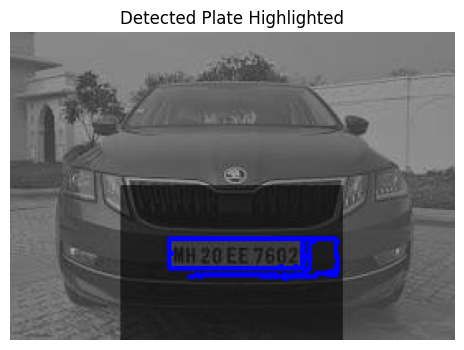

In [3]:
image_path = '/kaggle/input/cv-hw1-dataset/car.jpg'
image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

thresholded = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 11, 2)

contours, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plate_contour = None

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / float(h)
    
    if 2 < aspect_ratio < 6 and 500 < cv2.contourArea(contour) < 5000:
        plate_contour = contour
        break

if plate_contour is not None:
    image_with_contours = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(image_with_contours, [plate_contour], -1, (255, 0, 0), 2)
    
    x, y, w, h = cv2.boundingRect(plate_contour)
    plate_image = image_gray[y:y+h, x:x+w]

    plate_text = pytesseract.image_to_string(plate_image, config='--psm 8').strip()
    print("Detected License Plate Text:", plate_text)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title("Detected Plate Highlighted")
    plt.axis("off")
    plt.show()
else:
    print("No license plate contour found.")


# Q2: detect stars

In [4]:
from scipy.ndimage import label, find_objects
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [5]:
import numpy as np
from scipy.ndimage import label, find_objects

# Load grayscale image data from input1.txt
file_path = '/kaggle/input/cv-hw1-dataset/input1.txt'
with open(file_path, 'r') as file:
    data = file.readlines()

# Parse the grayscale values
image_data = []
for line in data:
    row = [int(pixel.split(",")[0].strip("()")) for pixel in line.replace("(", "").replace(")", "").split() if pixel]
    if len(row) == 732:  # Assume rows with 732 entries are valid
        image_data.append(row)

# Convert corrected data to numpy array
image_array = np.array(image_data)

# Threshold the image with a higher value to focus on bright, larger stars
threshold = 200  # Higher threshold to capture only very bright pixels
binary_mask = image_array > threshold

# Label connected components
labeled_array, num_features = label(binary_mask)

# Set a minimum size for contours to be considered as stars
min_size = 20  # Minimum number of pixels in a contour to qualify as a star

# Filter and calculate the center of each large contour
star_positions = []
for region in find_objects(labeled_array):
    if region is not None:
        # Calculate the size of the contour
        size = (region[0].stop - region[0].start) * (region[1].stop - region[1].start)
        if size >= min_size:
            # Calculate center of the star
            center_y = (region[0].start + region[0].stop) // 2
            center_x = (region[1].start + region[1].stop) // 2
            star_positions.append((center_y, center_x))

# Output the number of detected stars and their positions
print(f"Number of detected stars: {len(star_positions)}")
print("Star positions:", star_positions)


Number of detected stars: 12
Star positions: [(87, 102), (131, 271), (142, 475), (145, 457), (154, 471), (171, 174), (207, 354), (215, 69), (219, 466), (261, 469), (271, 702), (297, 672)]


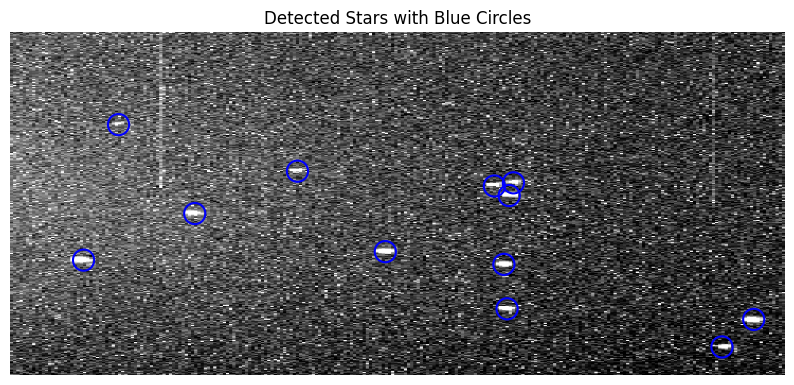

In [6]:
# Plot the image and overlay green circles around each detected star
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_array, cmap='gray')

# Iterate over star positions and draw a green circle around each
for (y, x) in star_positions:
    circle = Circle((x, y), radius=10, color='blue', fill=False, linewidth=1.5)
    ax.add_patch(circle)

# Display the result
plt.title("Detected Stars with Blue Circles")
plt.axis("off")  # Hide the axes for better visualization
plt.show()

# Q3: denoising with NLM

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

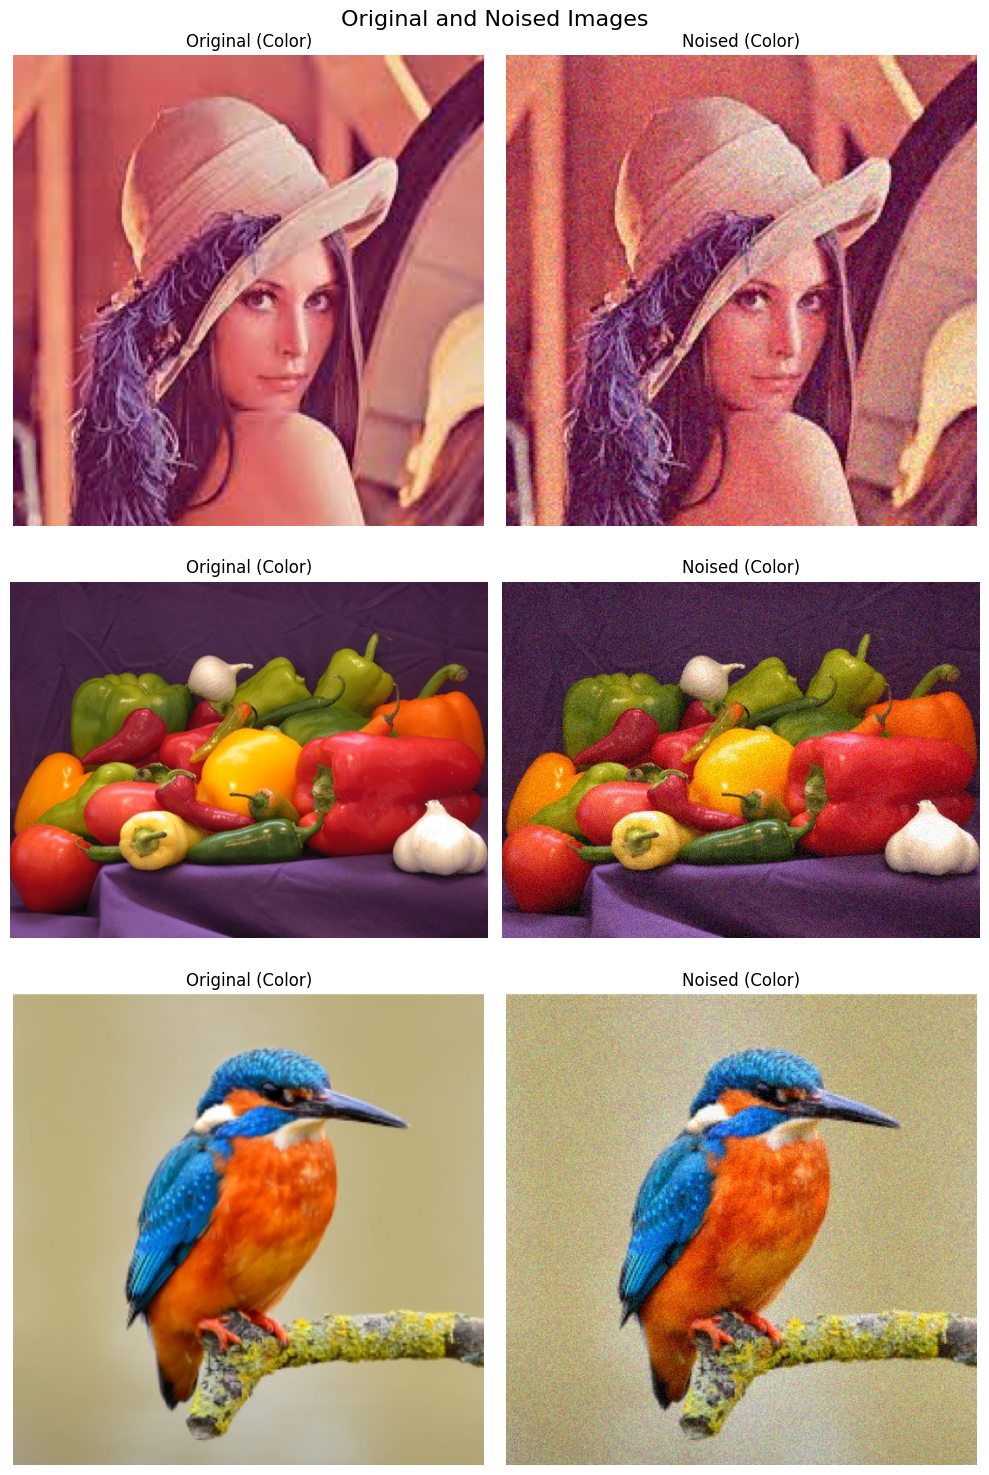

In [8]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define paths to the images
image_paths = [
    "/kaggle/input/cv-hw1-dataset/woman.jpg",
    "/kaggle/input/cv-hw1-dataset/vegetables.jpg",
    "/kaggle/input/cv-hw1-dataset/bird.jpg"
]

def add_gaussian_noise(image, mean=0, standard_deviation=15):
    # Apply noise to each color channel separately
    gaussian_noise = np.random.normal(mean, standard_deviation, image.shape).astype(np.float32)
    noisy_img = image.astype(np.float32) + gaussian_noise
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

# Load images, apply noise, and plot side by side
fig, axes = plt.subplots(len(image_paths), 2, figsize=(10, 15))
fig.suptitle("Original and Noised Images", fontsize=16)

for i, image_path in enumerate(image_paths):
    # Load image in color (unchanged)
    image = cv2.imread(image_path)

    # Convert image from BGR (OpenCV) to RGB (Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply Gaussian noise
    noised_image_rgb = add_gaussian_noise(image_rgb)

    # Save noised image
    noised_image_path = f"/kaggle/working/noised_image_{i+1}.jpg"
    cv2.imwrite(noised_image_path, cv2.cvtColor(noised_image_rgb, cv2.COLOR_RGB2BGR))

    # Plot original and noised images
    axes[i, 0].imshow(image_rgb)
    axes[i, 0].set_title("Original (Color)")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(noised_image_rgb)
    axes[i, 1].set_title("Noised (Color)")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


# CPU timing

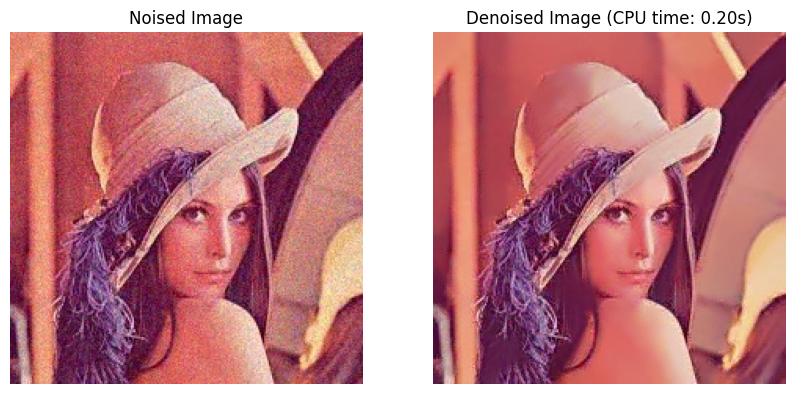

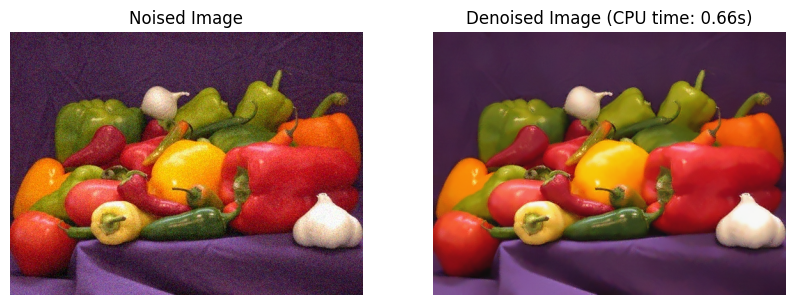

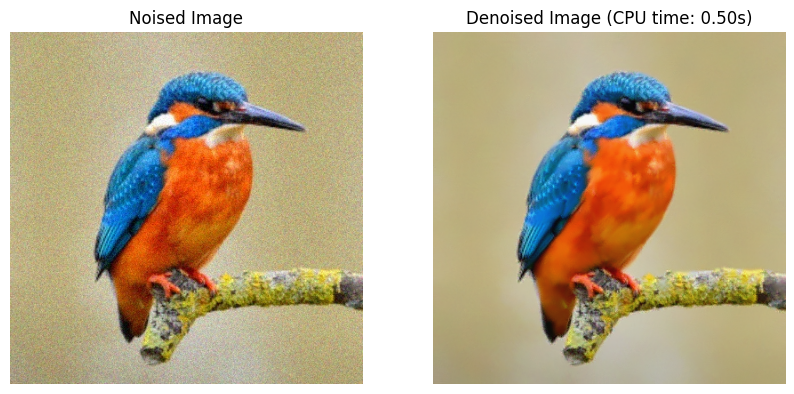

CPU time for image 1: 0.20 seconds
CPU time for image 2: 0.66 seconds
CPU time for image 3: 0.50 seconds


In [9]:
# Define paths to the noised images
noised_image_paths = [
    "/kaggle/working/noised_image_1.jpg",
    "/kaggle/working/noised_image_2.jpg",
    "/kaggle/working/noised_image_3.jpg"
]

# List to store CPU processing times for denoising
CPU_times = []

# Load noised images, denoise, and display
for i, noised_image_path in enumerate(noised_image_paths):
    # Load the noised image in color
    noised_image = cv2.imread(noised_image_path)
    
    # Convert image from BGR (OpenCV default) to RGB for display in Matplotlib
    noised_image_rgb = cv2.cvtColor(noised_image, cv2.COLOR_BGR2RGB)

    # Start timing the denoising process
    start_time = time.time()

    # Apply Non-Local Means denoising on each color channel separately
    denoised_channels = [
        cv2.fastNlMeansDenoising(noised_image_rgb[:, :, channel], None, h=10, templateWindowSize=7, searchWindowSize=21)
        for channel in range(3)
    ]

    # Stack the denoised channels back into an image
    denoised_image_rgb = cv2.merge(denoised_channels)

    # Record the time taken for denoising
    CPU_time = time.time() - start_time
    CPU_times.append(CPU_time)

    # Display noised and denoised images side by side
    plt.figure(figsize=(10, 5))
    
    # Noised Image
    plt.subplot(1, 2, 1)
    plt.imshow(noised_image_rgb)
    plt.title("Noised Image")
    plt.axis("off")

    # Denoised Image
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_image_rgb)
    plt.title(f"Denoised Image (CPU time: {CPU_time:.2f}s)")
    plt.axis("off")

    plt.show()

# Display the CPU times for each image
for idx, time_taken in enumerate(CPU_times):
    print(f"CPU time for image {idx + 1}: {time_taken:.2f} seconds")


# GPU timing

In [10]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from itertools import product 
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from typing import Tuple, List

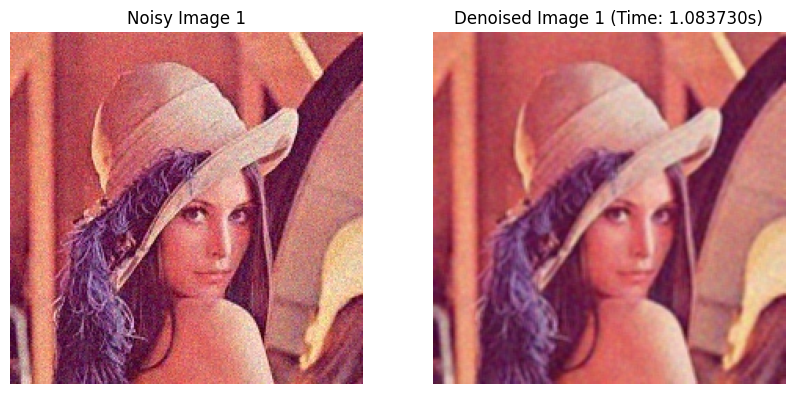

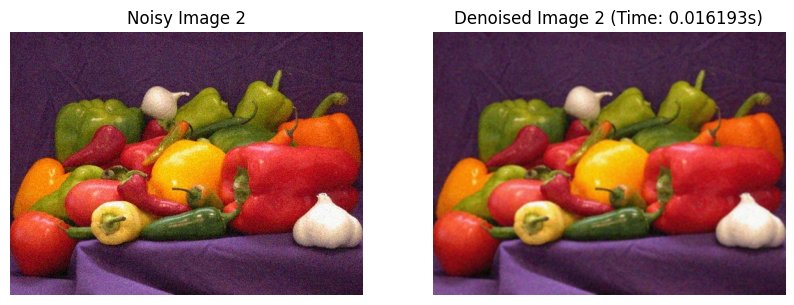

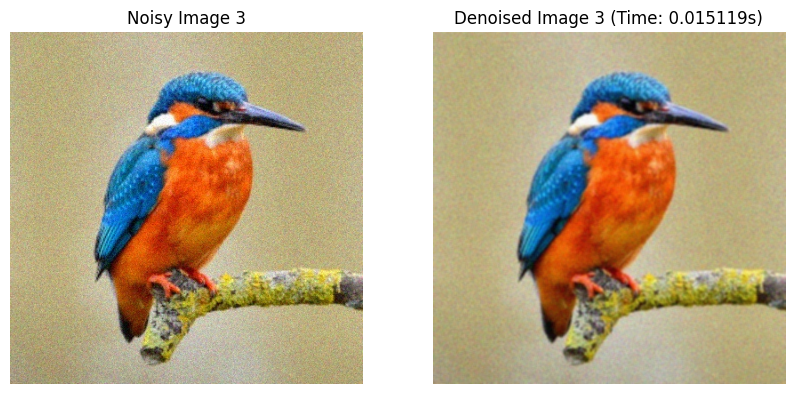

In [11]:
def get_gaussian_kernel(kernel_size: int = 5, sigma: float = 1., ndim: int = 2) -> torch.Tensor:
    ax = torch.linspace(-(kernel_size - 1) / 2., (kernel_size - 1) / 2., kernel_size)
    gauss = torch.exp(-0.5 * ax**2 / sigma**2)
    if ndim == 1:
        kernel = gauss
    elif ndim == 2:
        kernel = torch.outer(gauss, gauss)
    elif ndim == 3:
        kernel = gauss[None, None, :] * gauss[None, :, None] * gauss[:, None, None]
    return kernel / kernel.sum()

def unsqueeze_tensor_at_dim(X: torch.Tensor, ndim: int, dim: int = 0) -> torch.Tensor:
    diff = ndim - len(X.shape)
    for _ in range(diff):
        X = X.unsqueeze(dim)
    return X

def make_neighbours_kernel(kernel_size: int = 3, ndim: int = 2) -> torch.Tensor:
    K = kernel_size ** ndim
    filter = torch.zeros([K, 1, *[kernel_size for _ in range(ndim)]])
    generators = [range(kernel_size) for _ in range(ndim)]
    for i, coord in enumerate(product(*generators)):
        if ndim == 2:
            filter[i, :, coord[0], coord[1]] = 1
        elif ndim == 3:
            filter[i, :, coord[0], coord[1], coord[2]] = 1
    return filter

def get_neighbours(X: torch.Tensor, kernel_size: int = 3, ndim: int = 2) -> torch.Tensor:
    filter = make_neighbours_kernel(kernel_size, ndim).to(X.device)
    if ndim == 2:
        return F.conv2d(X, filter, padding=0)
    elif ndim == 3:
        return F.conv3d(X, filter, padding=0)
    else:
        raise NotImplementedError("ndim must be 2 or 3.")

def apply_mean_filter(X: torch.Tensor, kernel_size: int = 3, ndim: int = 2) -> torch.Tensor:
    filter = torch.ones([kernel_size] * ndim).to(X.device) / kernel_size**ndim
    filter = unsqueeze_tensor_at_dim(filter, ndim + 2)
    pad = kernel_size // 2
    padding = (pad,) * (ndim * 2)
    X = F.pad(X, padding, mode="reflect")
    if ndim == 2:
        return F.conv2d(X, filter, padding=0)
    elif ndim == 3:
        return F.conv3d(X, filter, padding=0)
    else:
        raise NotImplementedError("ndim must be 2 or 3.")

def non_local_means_loop_index(X: torch.Tensor, kernel_size: int = 3, ndim: int = 2, sub_filter_size: int = 1, std: float = 1.0) -> torch.Tensor:
    def cat_idxs(idxs: List[torch.Tensor]):
        return torch.cat(idxs, 1)

    def preprocess_idxs(idxs: List[torch.Tensor], original_idxs: List[torch.Tensor], sizes: List[int]):
        d = torch.abs(original_idxs - idxs)
        idxs = torch.where(idxs < 0, d - original_idxs, idxs)
        idxs = torch.where(idxs > sizes - 1, original_idxs - d, idxs)
        return idxs

    def weight_operation(X, neighbours, std_2):
        return torch.exp(-((X - neighbours) ** 2) / std_2)

    def calculate_weights_2d(X, idxs, std_2):
        n = len(idxs)
        idxs = cat_idxs(idxs)
        neighbours = X[:, :, idxs[0], idxs[1]].reshape(1, n, X.shape[2], X.shape[3])
        weights = weight_operation(X, neighbours, std_2)
        return weights, neighbours

    weights_sum = torch.zeros_like(X)
    output = torch.zeros_like(X)
    k2 = kernel_size // 2
    std_2 = std ** 2
    if ndim == 2:
        _, _, H, W = X.shape
        coords = torch.stack(torch.where(X[0, 0] == X[0, 0]))
        tmp_idxs = torch.zeros_like(coords)
        size = torch.as_tensor([H, W], device=X.device).reshape(ndim, 1)
        all_idxs = []
        range_h = torch.arange(-k2, k2 + 1)
        range_w = torch.arange(-k2, k2 + 1)
        for i, j in product(range_h, range_w):
            tmp_idxs[0][:] = coords[0] + i
            tmp_idxs[1][:] = coords[1] + j
            all_idxs.append(preprocess_idxs(tmp_idxs, coords, size))
            weights, neighbours = calculate_weights_2d(X, all_idxs, std_2)
            weights_sum += torch.sum(weights, 1)
            output += weights.mul(neighbours).sum(1)
            all_idxs = []
        if all_idxs:
            weights, neighbours = calculate_weights_2d(X, all_idxs, std_2)
            weights_sum += torch.sum(weights, 1)
            output += weights.mul(neighbours).sum(1)

    return output / weights_sum

def apply_nonlocal_means_2d_mem_efficient(X: torch.Tensor, kernel_size: int = 3, std: float = 1, kernel_size_mean: int = 3, sub_filter_size: int = 256) -> torch.Tensor:
    ndim = 2
    X = unsqueeze_tensor_at_dim(X, ndim + 2)
    X = apply_mean_filter(X, kernel_size_mean, ndim)
    output = non_local_means_loop_index(X, kernel_size=kernel_size, std=std, ndim=ndim, sub_filter_size=sub_filter_size)
    return output.squeeze(0).squeeze(0)

# Kaggle-specific implementation with timing and plotting
def load_and_denoise_images_color(image_paths, kernel_size=3, std=1.0, kernel_size_mean=3):
    denoised_images = []
    for image_path in image_paths:
        # Load the image in color mode
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        # Split image into color channels (BGR in OpenCV)
        channels = cv2.split(img)
        
        # Denoise each channel separately
        denoised_channels = []
        start_time = time.time()
        for channel in channels:
            # Convert channel to tensor and move to GPU
            channel_tensor = torch.tensor(channel, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to('cuda')
            # Apply NLM denoising on the channel
            denoised_channel_tensor = apply_nonlocal_means_2d_mem_efficient(channel_tensor, kernel_size=kernel_size, std=std, kernel_size_mean=kernel_size_mean)
            denoised_channel = denoised_channel_tensor.cpu().numpy().astype(np.uint8)
            denoised_channels.append(denoised_channel)
        
        end_time = time.time()
        denoise_time = end_time - start_time
        
        # Merge denoised channels back into a color image
        denoised_img = cv2.merge(denoised_channels)
        denoised_images.append((img, denoised_img, denoise_time))
    
    return denoised_images

# List of image paths (adjust paths as needed on Kaggle)
image_paths = [
    '/kaggle/working/noised_image_1.jpg',
    '/kaggle/working/noised_image_2.jpg',
    '/kaggle/working/noised_image_3.jpg'
]

# Load, denoise, and measure time for each image
denoised_images = load_and_denoise_images_color(image_paths)

# Plot results
for i, (noisy_img, denoised_img, denoise_time) in enumerate(denoised_images, start=1):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Noisy Image {i}")
    plt.imshow(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Denoised Image {i} (Time: {denoise_time:.6f}s)")
    plt.imshow(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()


Denoising Time Comparison (in seconds):
Woman - CPU: 0.204015s, GPU: 1.083730s
Vegetables - CPU: 0.657469s, GPU: 0.016193s
Bird - CPU: 0.501825s, GPU: 0.015119s


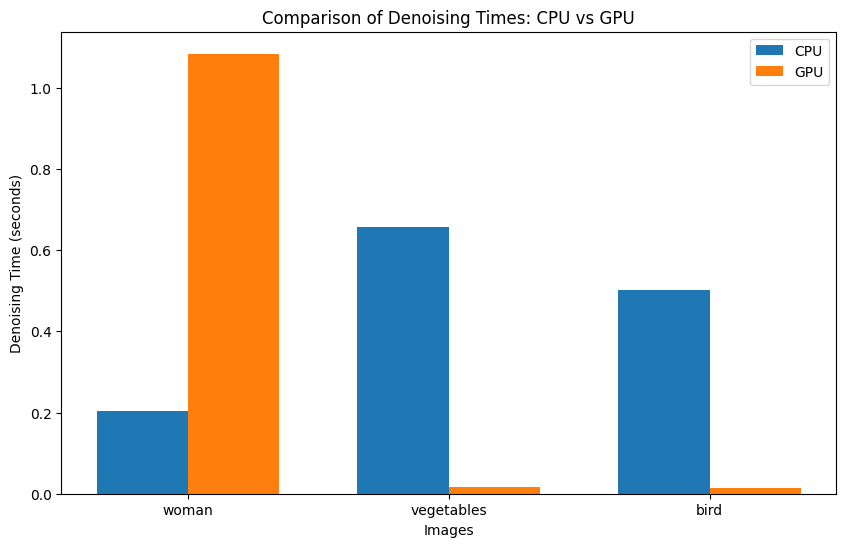

In [12]:
import matplotlib.pyplot as plt

# Names of the images
image_names = ['woman', 'vegetables', 'bird']

# Extract GPU times from denoised_images
GPU_times = [denoise_time for _, _, denoise_time in denoised_images]

# Example CPU times (replace with your actual times)
# CPU_times = [time_woman, time_vegetables, time_bird]  # Uncomment and define this list with actual values
# CPU_times should already be provided in the correct order for comparison.

# Display times for both GPU and CPU
print("Denoising Time Comparison (in seconds):")
for name, cpu_time, gpu_time in zip(image_names, CPU_times, GPU_times):
    print(f"{name.capitalize()} - CPU: {cpu_time:.6f}s, GPU: {gpu_time:.6f}s")

# Plotting the comparison
fig, ax = plt.subplots(figsize=(10, 6))
index = range(len(image_names))
bar_width = 0.35

# Create bars for CPU and GPU times
cpu_bars = plt.bar(index, CPU_times, bar_width, label='CPU')
gpu_bars = plt.bar([i + bar_width for i in index], GPU_times, bar_width, label='GPU')

# Adding labels and title
plt.xlabel('Images')
plt.ylabel('Denoising Time (seconds)')
plt.title('Comparison of Denoising Times: CPU vs GPU')
plt.xticks([i + bar_width / 2 for i in index], image_names)
plt.legend()

# Show the plot
plt.show()
